In [239]:
import xarray as xr
import h5py
import numpy as np
import os
import warnings
import xarray as xr
from scipy.integrate import quad
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, maskoceans


In [240]:
def xarray_haversine_index2d(lon_dat, lat_dat, lon0, lat0):
    '''
    function calculates nearest j-i index to lat-lon pair within a xarray.dataarray
    '''

    # input:
    #
    # xr_dataarray : xarray.DataArray whose parent
    #   xarray.DataSet to which
    #   metpy.xarray.MetPyDataArrayAccessor.parse_cf() and
    #   metpy.xarray.MetPyDataArrayAccessor.assign_latitude_longitude()
    #   has been applied
    #
    # lon0 : Target Longitude
    #   Must be a scalar floating point
    #   (units presumed to be in degrees_east)
    #
    # lat0 : Target Latitude.
    #   Must be a scalar floating point
    #   (units presumed to be degrees_north)

    # return output:
    #   xarray_haversine_index2d() : J and I of
    #   values in xr_dataarray that are the
    #   closest in surface sphere distance to
    #   the requested latitude and longitude.
    #   Tuple: numpy.array(2, dtype=int64)

    phi2d = np.radians(lat_dat)
    lam2d = np.radians(lon_dat)

    phi0 = np.radians(lat0)
    lam0 = np.radians(lon0)

    haversine_2d = np.arcsin(np.sqrt(np.sin((phi2d - phi0) / 2) ** 2 +
                                     np.cos(phi0) * np.cos(phi2d) * np.sin((lam2d - lam0) / 2) ** 2))
    ji = np.nanargmin(haversine_2d)
    ji_2d = np.unravel_index(ji, lam2d.shape)
    return (ji_2d)


def goes_array(dat, lon0, lat0):
    target_i = xarray_haversine_index2d(lon_dat=dat[2],
                                                  lat_dat=dat[1],
                                                  lon0=lon0,
                                                  lat0=lat0)
    print(dat[0][target_i])
    with warnings.catch_warnings(record=True):
        warnings.filterwarnings("error")
        try:
            out_target = dat[0][target_i]
        except UserWarning:
            out_target = np.nan
    return out_target

def trap(f, n):
    h = 1 / float(n)
    intgr = 0.5 * h * (f(0) + f(1))
    for i in range(1, int(n)):
        intgr = intgr + h * f(i * h)
    return intgr

In [241]:
Socorro_lon, Socorro_lat = -106.9056, 34.0660
ABQ_lon, ABQ_lat = -106.6221, 35.0376
EPZ_lon, EPZ_lat = -106.6982, 31.872
#os.system("tar -xvf ./nucaps/raw/*.tar -C ./nucaps/data/")

f1 = xr.open_dataset("./nucaps/data/NUCAPS-EDR_v2r0_j01_s202007200843350_e202007200844050_c202007200927160.nc", decode_times=False)
f2 = xr.open_dataset("./nucaps/data/NUCAPS-EDR_v2r0_j01_s202007200844070_e202007200844370_c202007200927480.nc", decode_times=False)
f3 = xr.open_dataset("./nucaps/data/NUCAPS-EDR_v2r0_j01_s202007200849270_e202007200849570_c202007200928400.nc", decode_times=False)
f4 = xr.open_dataset("./nucaps/data/NUCAPS-EDR_v2r0_j01_s202007200853110_e202007200853410_c202007200931290.nc", decode_times=False)
#sYYYYMMDDHHMMSSms
#s202007200849270

lon = []
lat = []
# for f in Path("./nucaps/data/").glob("*.nc"):
#     file = xr.open_dataset(f, decode_times=False)
#     target_i = xarray_haversine_index2d(lon_dat=file["Longitude"].values,
#                                         lat_dat=file["Latitude"].values,
#                                         lon0=Socorro_lon,
#                                         lat0=Socorro_lat)
    #print("{}, {}".format(file["Latitude"][target_i].values, file["Longitude"][target_i].values))


target = {"ABQ": {"lon": -106.6221, "lat": 35.0376}, # Albuquerque, NM WFO coordinates
          "EPZ": {"lon": -106.6982, "lat": 31.8728}, # Santa Teresa, NM WFO coordinates
          "Socorro": {"lon": -106.9056, "lat": 34.0660}}
          
for i in target:
    print(i)
    target_i = xarray_haversine_index2d(lon_dat=f4["Longitude"].values,
                                            lat_dat=f4["Latitude"].values,
                                            lon0=target[i]["lon"],
                                            lat0=target[i]["lat"])
    print("lon: {}, lat: {}".format(target[i]["lon"], target[i]["lat"]))
    print("lon: {:.4f}, lat: {:.4f}".format(f4["Longitude"][target_i].values, f4["Latitude"][target_i].values))
    inte = 1./(9.81 * 997) * np.trapz(f4["H2O_MR"][target_i].values, x=f4["Pressure"][target_i].values * 100) * 1000
    print(inte)

ABQ
lon: -106.6221, lat: 35.0376
lon: -106.7904, lat: 35.2016
43.73961853745807
EPZ
lon: -106.6982, lat: 31.8728
lon: -106.0173, lat: 34.1334
43.63664799528076
Socorro
lon: -106.9056, lat: 34.066
lon: -107.0595, lat: 34.2674
48.711852939041385


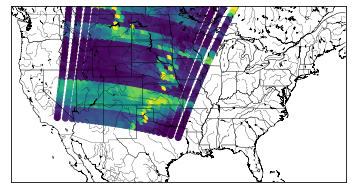

In [280]:
bbox = [-126, 25, -65 , 50]
n_add = 0
plt.figure()
m = Basemap(
    llcrnrlon=bbox[0] - n_add,
    llcrnrlat=bbox[1] - n_add,
    urcrnrlon=bbox[2] + n_add,
    urcrnrlat=bbox[3] + n_add,
    resolution='i',
    projection="merc")

m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.25)
m.drawstates(linewidth=0.25)
m.drawrivers(linewidth=0.25)

for f in Path("./nucaps/data/").glob("*.nc"):
    file = xr.open_dataset(f, decode_times=False)
    Plvl = np.array(file.sel(Number_of_CrIS_FORs=0).Pressure.values, dtype='i4')
    Pindx = {}


    for i, plev in enumerate(Plvl):
        Pindx.update({plev: i})

    gridView = file.sel(Number_of_P_Levels=Pindx[515])
   
    lon, lat = m(gridView["Longitude"], gridView["Latitude"])
    m.scatter(lon, lat, c=gridView["H2O_MR"])

plt.show()

